# Код проекта по предсказанию стоимостей жилья в Москве

Авторы:
- Равнушкин Тимофей
- Акулов Артём
- Шейкис Марк

## Загрузка и подготовка данных

In [21]:
import pandas as pd

In [22]:
df = pd.read_csv("dataset.csv")
# переменная, не описанная в описании датасета и непонятно что значащая
df = df.drop(["AVERAGE"], axis=1)
# удалим подмосковье
df = df[df["Region"] == "Moscow"]
df = df[df["Metro station"] != "Подольск"]
df = df[df["Metro station"] != "Нахабино"]
df = df[df["Metro station"] != "Битца"]
df = df.drop(["Region"], axis=1)
df

,Price,Apartment type,Metro station,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
314,108800000.0,Secondary,Чеховская,5.0,3.0,108.8,57.1,15.6,3.0,3,Without renovation
315,53000000.0,Secondary,Арбатская,9.0,3.0,96.9,59.0,11.1,2.0,5,Without renovation
316,44240000.0,Secondary,Фили,6.0,3.0,63.2,34.1,11.9,40.0,41,Designer
317,105000000.0,Secondary,Белорусская,6.0,3.0,145.0,75.4,18.6,3.0,6,Designer
318,47000000.0,Secondary,Белорусская,9.0,3.0,103.8,59.0,15.0,6.0,6,Without renovation
...,...,...,...,...,...,...,...,...,...,...,...
22642,14541800.0,New building,Аннино,7.0,2.0,79.9,42.5,13.3,6.0,22,Cosmetic
22643,14676600.0,New building,Аннино,7.0,2.0,80.2,42.7,13.3,8.0,22,Cosmetic
22644,13739550.0,New building,Аннино,7.0,2.0,75.7,40.4,12.9,5.0,22,Cosmetic
22645,8000000.0,New building,Царицыно,7.0,1.0,40.2,18.3,9.2,15.0,13,Cosmetic


In [23]:
# подгрузим данные о времени в пути от станций метро до Театральной, полученные с помощью сервиса Яндекс Метро

theatric_df = pd.read_csv("theatric.csv")
time_to_teatralnaya = dict()
for row in theatric_df.itertuples():
    rowdata = row[1]
    row_time = int(rowdata.split(" ")[-1])
    row_name = " ".join(rowdata.split(" ")[:-1])
    time_to_teatralnaya[row_name] = row_time

df["Time to Teatralnaya"] = df["Metro station"].map(time_to_teatralnaya)
df["Time to Teatralnaya"].isnull().sum()


0

In [24]:
# подгрузим данные об административных округах, полученные в parse_districts.ipynb
# названия станций приходится нормировать, убирая пробелы, буквы ё и меняя регистр

district_df = pd.read_csv("station_distr.csv")
station_districts = dict()
for row in district_df.itertuples():
    transname = row[1].lower()
    transname = transname.replace(" ", "")
    transname = transname.replace("ё", "е")
    station_districts[transname] = row[2]

station_districts["библиотекаиленина"] = "Центральный"
station_districts["библиотекаим.ленина"] = "Центральный"
station_districts["карамышевская"] = station_districts["народноеополчение"]
station_districts["зеленоград—крюково"] = "Зеленоградский"
station_districts["силикатная"] = "Новомосковский"
station_districts["новодачная"] = "Северо-Восточный"
station_districts["вешняки"] = station_districts["выхино"]
station_districts["немчиновка"] = "Западный"
station_districts["павшино"] = "Северо-Западный"
station_districts["хлебниково"] = "Северный"
station_districts["долгопрудная"] = "Северный"
station_districts["мякинино"] = "Западный"
station_districts["сколково"] = "Западный"


for station in df["Metro station"].unique():
    transname = station.lower()
    transname = transname.replace(" ", "")
    transname = transname.replace("ё", "е")
    transname = transname.split("(")[0]
    station_districts[station] = station_districts[transname]

df["District"] = df["Metro station"].map(station_districts).fillna("Область")
df

,Price,Apartment type,Metro station,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation,Time to Teatralnaya,District
314,108800000.0,Secondary,Чеховская,5.0,3.0,108.8,57.1,15.6,3.0,3,Without renovation,7,Центральный
315,53000000.0,Secondary,Арбатская,9.0,3.0,96.9,59.0,11.1,2.0,5,Without renovation,11,Центральный
316,44240000.0,Secondary,Фили,6.0,3.0,63.2,34.1,11.9,40.0,41,Designer,29,Западный
317,105000000.0,Secondary,Белорусская,6.0,3.0,145.0,75.4,18.6,3.0,6,Designer,10,Центральный
318,47000000.0,Secondary,Белорусская,9.0,3.0,103.8,59.0,15.0,6.0,6,Without renovation,10,Центральный
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22642,14541800.0,New building,Аннино,7.0,2.0,79.9,42.5,13.3,6.0,22,Cosmetic,42,Южный
22643,14676600.0,New building,Аннино,7.0,2.0,80.2,42.7,13.3,8.0,22,Cosmetic,42,Южный
22644,13739550.0,New building,Аннино,7.0,2.0,75.7,40.4,12.9,5.0,22,Cosmetic,42,Южный
22645,8000000.0,New building,Царицыно,7.0,1.0,40.2,18.3,9.2,15.0,13,Cosmetic,29,Южный


## Предварительный анализ

(14, 13)


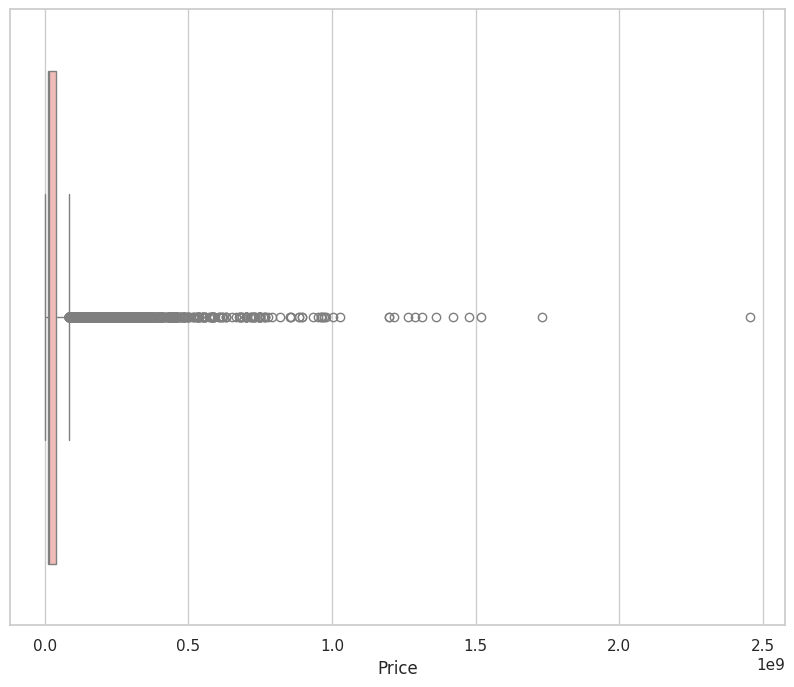

In [25]:
import seaborn as sns

sns.set_theme(rc={"figure.figsize": (10, 8)}, palette="Pastel1", style="whitegrid")

sns.boxplot(data=df, x="Price")

# убираем выбросы
print(df[df["Price"] >= 1e9].shape)
df = df[df["Price"] < 1e9]

In [26]:
df

,Price,Apartment type,Metro station,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation,Time to Teatralnaya,District
314,108800000.0,Secondary,Чеховская,5.0,3.0,108.8,57.1,15.6,3.0,3,Without renovation,7,Центральный
315,53000000.0,Secondary,Арбатская,9.0,3.0,96.9,59.0,11.1,2.0,5,Without renovation,11,Центральный
316,44240000.0,Secondary,Фили,6.0,3.0,63.2,34.1,11.9,40.0,41,Designer,29,Западный
317,105000000.0,Secondary,Белорусская,6.0,3.0,145.0,75.4,18.6,3.0,6,Designer,10,Центральный
318,47000000.0,Secondary,Белорусская,9.0,3.0,103.8,59.0,15.0,6.0,6,Without renovation,10,Центральный
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22642,14541800.0,New building,Аннино,7.0,2.0,79.9,42.5,13.3,6.0,22,Cosmetic,42,Южный
22643,14676600.0,New building,Аннино,7.0,2.0,80.2,42.7,13.3,8.0,22,Cosmetic,42,Южный
22644,13739550.0,New building,Аннино,7.0,2.0,75.7,40.4,12.9,5.0,22,Cosmetic,42,Южный
22645,8000000.0,New building,Царицыно,7.0,1.0,40.2,18.3,9.2,15.0,13,Cosmetic,29,Южный


<Axes: xlabel='Number of rooms', ylabel='Count'>

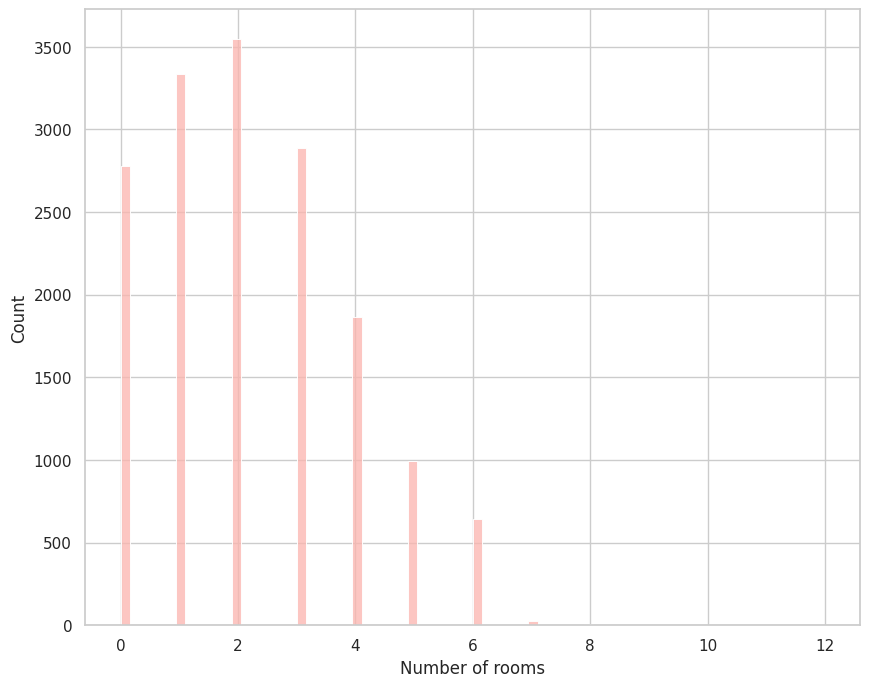

In [27]:
sns.histplot(data=df, x="Number of rooms")

/tmp/ipykernel_1438478/3656167835.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="coolwarm")


<Axes: >

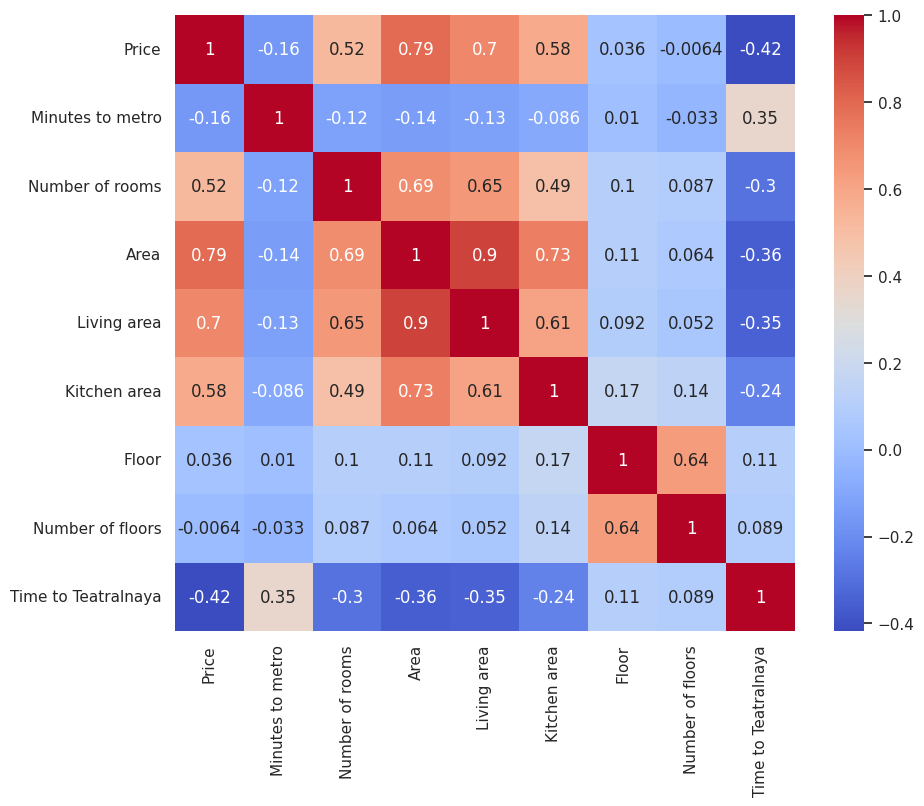

In [28]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

Центральный ЦАО
Западный ЗАО
Северо-Восточный СВАО
Северный САО
Новомосковский НАО
Северо-Западный СЗАО
Южный ЮАО
Восточный ВАО
Юго-Восточный ЮВАО
Юго-Западный ЮЗАО
Зеленоградский ЗелАО


<Axes: xlabel='District', ylabel='Price'>

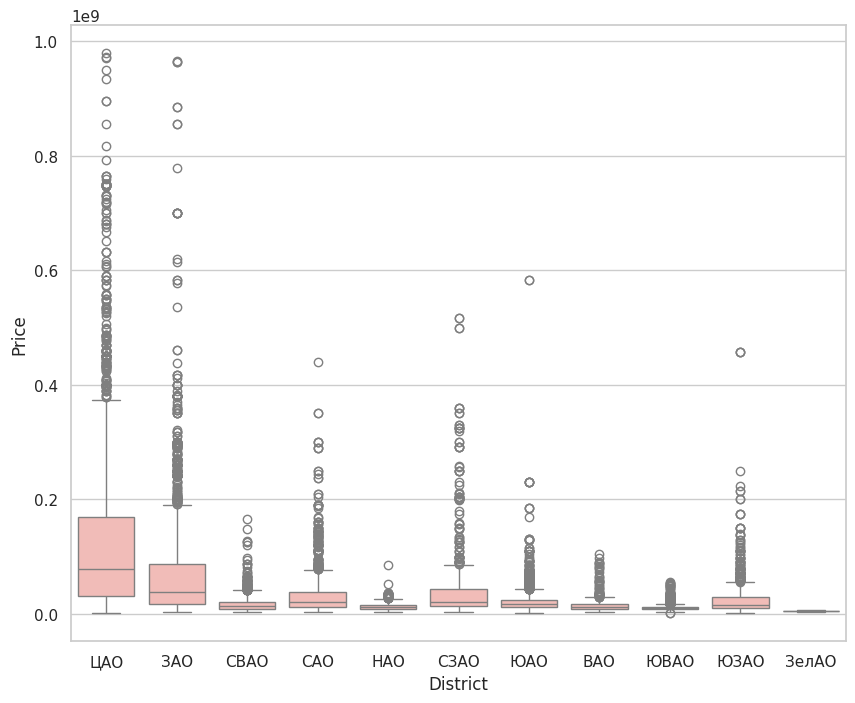

In [29]:
codemap = dict()
for district in df["District"].unique():
    code = ""
    for word in district.split("-"):
        code += word[0]
    code += "АО"
    if district == "Зеленоградский":
        code = "ЗелАО"
    codemap[district] = code
    print(district, code)
sns.boxplot(data=df, x=df["District"].map(codemap), y="Price")

<Axes: xlabel='Price', ylabel='Count'>

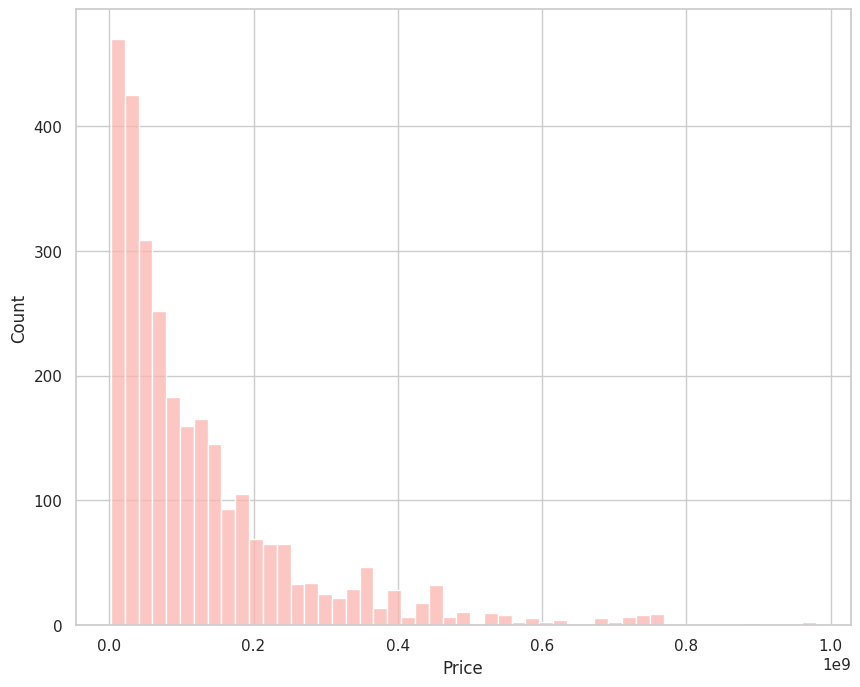

In [30]:
sns.histplot(data=df[df["District"] == "Центральный"], x="Price")

<Axes: xlabel='Renovation', ylabel='Price'>

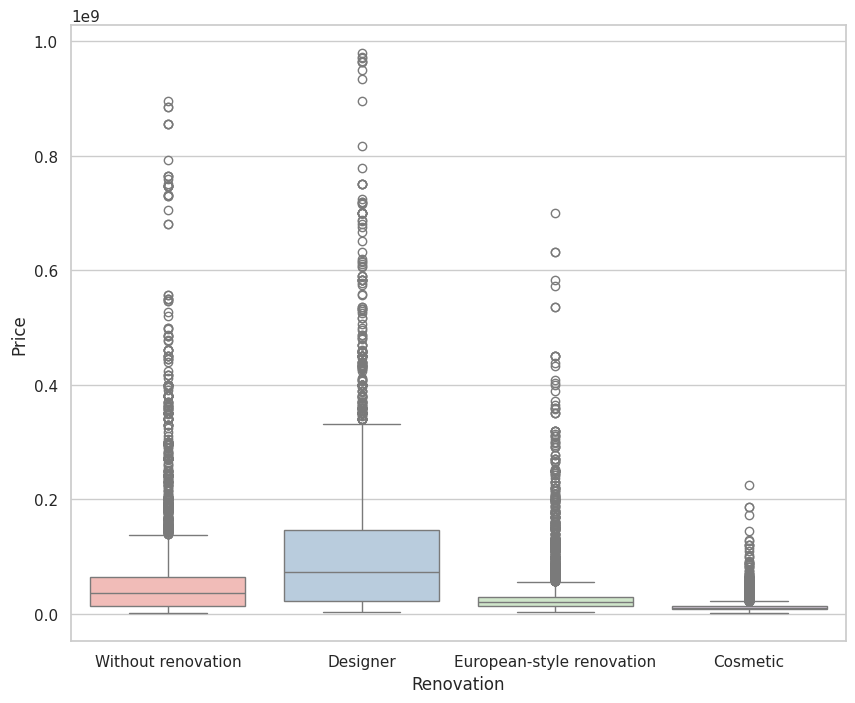

In [31]:
sns.boxplot(data=df, x="Renovation", y="Price", hue="Renovation", legend=False)

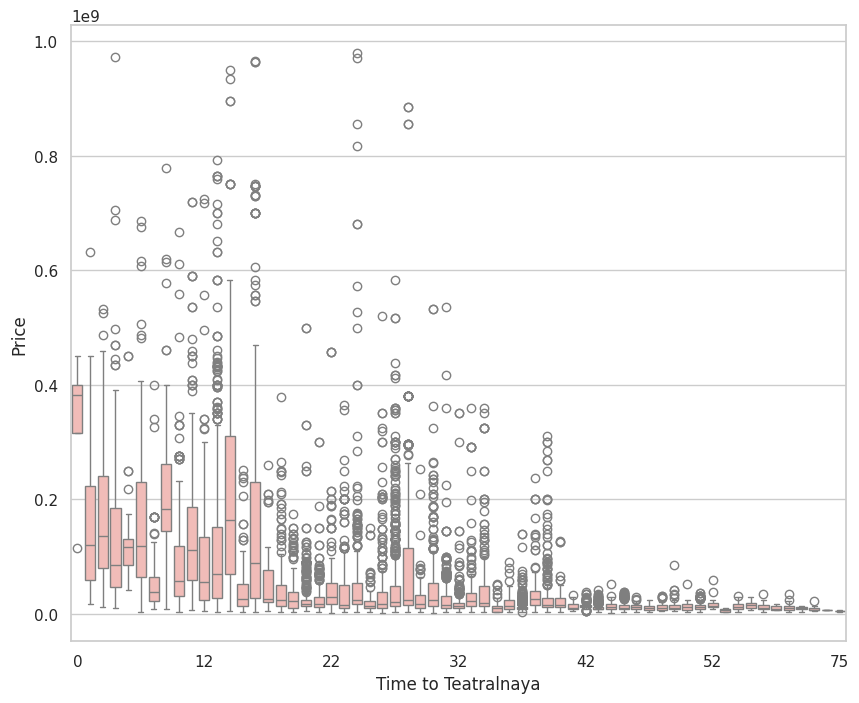

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.boxplot(
    x=(df["Time to Teatralnaya"]),
    y=df["Price"],
)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
plt.show()

<Axes: xlabel='Area', ylabel='Price'>

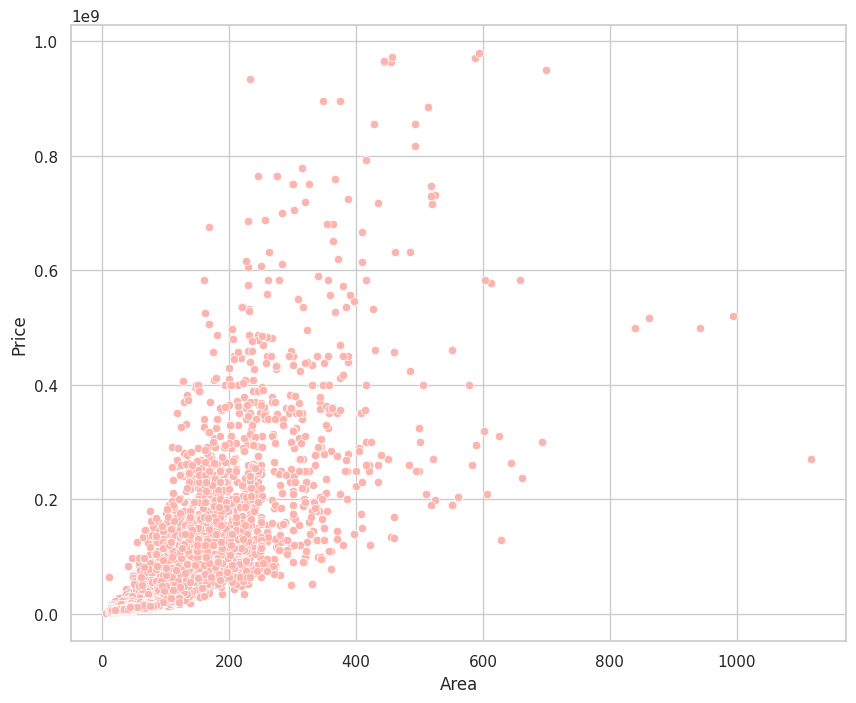

In [33]:
sns.scatterplot(data=df, x="Area", y="Price")

<Axes: xlabel='Number of rooms', ylabel='None'>

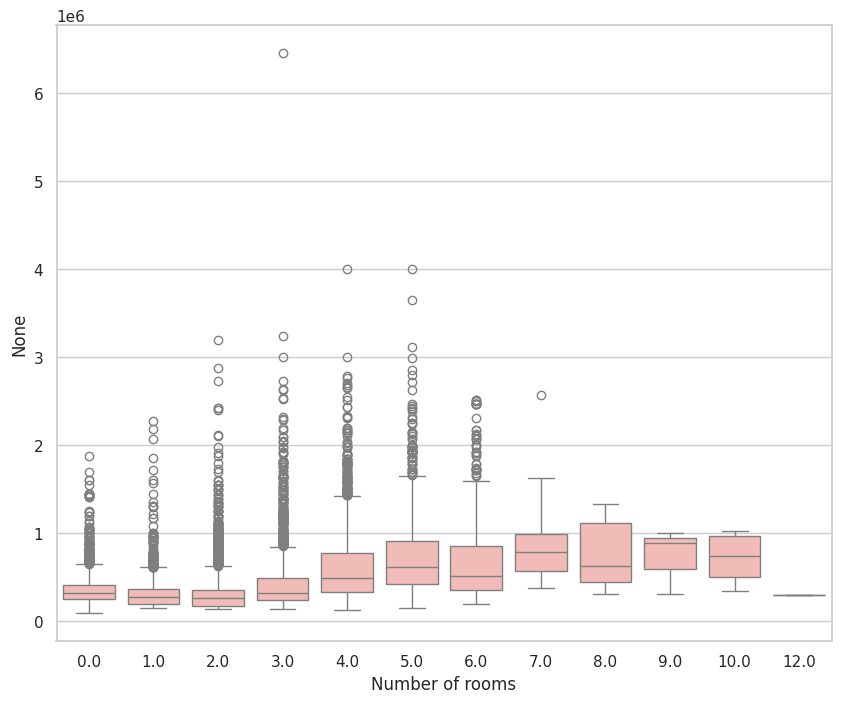

In [34]:
sns.boxplot(data=df, x="Number of rooms", y=df["Price"] / df["Area"])

In [35]:
df.groupby("District").median()

/tmp/ipykernel_1438478/1136203411.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("District").median()


,Price,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Time to Teatralnaya
District,,,,,,,,,
Восточный,12500000.0,13.0,2.0,42.90,24.0,8.5,4.0,12.0,27.0
Западный,37705000.0,11.5,3.0,86.00,46.6,14.0,8.0,17.0,29.0
Зеленоградский,4650000.0,13.0,0.0,15.00,11.8,7.9,3.0,9.0,75.0
Новомосковский,11200000.0,15.0,1.0,42.00,20.0,11.0,7.0,16.0,49.0
Северный,19970000.0,11.0,2.0,56.20,30.0,10.0,7.0,16.0,31.0
Северо-Восточный,13700000.0,12.0,1.0,44.15,25.0,8.7,6.0,14.0,30.0
Северо-Западный,20993400.0,12.0,2.0,62.40,33.5,11.8,8.0,19.0,27.0
Центральный,78000000.0,8.0,3.0,114.20,59.0,15.9,5.0,9.0,13.0
Юго-Восточный,9968220.0,14.0,1.0,44.82,24.4,11.2,9.0,11.0,43.0


## Проверка статистических гипотез

In [36]:
%pip install statsmodels

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [37]:
import statsmodels.api as sm

x = df["Area"]
x = sm.add_constant(x)
y = df["Price"]
model = sm.OLS(y, x)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                 2.707e+04
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:09:15   Log-Likelihood:            -3.0902e+05
No. Observations:               16093   AIC:                         6.181e+05
Df Residuals:                   16091   BIC:                         6.181e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.62e+07   6.09e+05    -43.030      0.000   -2.74e+07    -2.5e+07
Area        8.964e+05   5448.850    164.516      0.000    8.86e+05    9.07e+05
==============================================================================
Omnibus:                    12872.527   Durbin-Watson:                   1.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           983154.568
Skew:                           3.308   Prob(JB):                         0.00
Kurtosis:                      40.715   Cond. No.                         163.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
x = df["Time to Teatralnaya"]
x = sm.add_constant(x)
y = df["Price"]
model = sm.OLS(y, x)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     3404.
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:09:15   Log-Likelihood:            -3.1542e+05
No. Observations:               16093   AIC:                         6.308e+05
Df Residuals:                   16091   BIC:                         6.309e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.346e+08   1.63e+06     82.710      0.000    1.31e+08    1.38e+08
Time to Teatralnaya -2.938e+06   5.04e+04    -58.341      0.000   -3.04e+06   -2.84e+06
==============================================================================
Omnibus:                    14857.887   Durbin-Watson:                   1.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           656623.202
Skew:                           4.449   Prob(JB):                         0.00
Kurtosis:                      33.001   Cond. No.                         84.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Подготовка датасета к обучению моделей

In [39]:
%pip install category_encoders scikit-learn

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [40]:
X = df.drop(["Price", "Metro station", "Living area", "Kitchen area", "Floor", "Number of floors"], axis=1)
y = df["Price"]

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [42]:
X_train

,Apartment type,Minutes to metro,Number of rooms,Area,Renovation,Time to Teatralnaya,District
14542,New building,19.0,0.0,27.25,Cosmetic,43,Юго-Восточный
7887,Secondary,33.0,3.0,79.70,European-style renovation,16,Центральный
6553,Secondary,19.0,2.0,66.80,Cosmetic,51,Юго-Восточный
2772,Secondary,17.0,0.0,44.00,Without renovation,17,Северный
6258,Secondary,21.0,2.0,45.00,European-style renovation,18,Южный
...,...,...,...,...,...,...,...
15433,New building,13.0,2.0,55.74,Cosmetic,37,Юго-Восточный
6053,Secondary,8.0,2.0,45.00,Designer,36,Южный
1514,Secondary,25.0,0.0,17.30,European-style renovation,48,Северо-Западный
21579,New building,4.0,3.0,74.30,European-style renovation,20,Южный


In [43]:
import category_encoders as ce

encoder = ce.OneHotEncoder(cols=["Apartment type", "Renovation", "District"])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
X_train

,Apartment type_1,Apartment type_2,Minutes to metro,Number of rooms,Area,Renovation_1,Renovation_2,Renovation_3,Renovation_4,Time to Teatralnaya,...,District_2,District_3,District_4,District_5,District_6,District_7,District_8,District_9,District_10,District_11
14542,1,0,19.0,0.0,27.25,1,0,0,0,43,...,0,0,0,0,0,0,0,0,0,0
7887,0,1,33.0,3.0,79.70,0,1,0,0,16,...,1,0,0,0,0,0,0,0,0,0
6553,0,1,19.0,2.0,66.80,1,0,0,0,51,...,0,0,0,0,0,0,0,0,0,0
2772,0,1,17.0,0.0,44.00,0,0,1,0,17,...,0,1,0,0,0,0,0,0,0,0
6258,0,1,21.0,2.0,45.00,0,1,0,0,18,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15433,1,0,13.0,2.0,55.74,1,0,0,0,37,...,0,0,0,0,0,0,0,0,0,0
6053,0,1,8.0,2.0,45.00,0,0,0,1,36,...,0,0,1,0,0,0,0,0,0,0
1514,0,1,25.0,0.0,17.30,0,1,0,0,48,...,0,0,0,0,0,0,0,1,0,0
21579,1,0,4.0,3.0,74.30,0,1,0,0,20,...,0,0,1,0,0,0,0,0,0,0


In [44]:
from sklearn.preprocessing import RobustScaler

cols = X_train.columns
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])
X_train

,Apartment type_1,Apartment type_2,Minutes to metro,Number of rooms,Area,Renovation_1,Renovation_2,Renovation_3,Renovation_4,Time to Teatralnaya,...,District_2,District_3,District_4,District_5,District_6,District_7,District_8,District_9,District_10,District_11
0,1.0,-1.0,0.7,-1.0,-0.605360,1.0,0.0,0.0,0.0,0.684211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.1,0.5,0.364140,0.0,1.0,0.0,0.0,-0.736842,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.7,0.0,0.125693,1.0,0.0,0.0,0.0,1.105263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.5,-1.0,-0.295749,0.0,0.0,1.0,0.0,-0.684211,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.9,0.0,-0.277264,0.0,1.0,0.0,0.0,-0.631579,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,1.0,-1.0,0.1,0.0,-0.078743,1.0,0.0,0.0,0.0,0.368421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12870,0.0,0.0,-0.4,0.0,-0.277264,0.0,0.0,0.0,1.0,0.315789,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12871,0.0,0.0,1.3,-1.0,-0.789279,0.0,1.0,0.0,0.0,0.947368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12872,1.0,-1.0,-0.8,0.5,0.264325,0.0,1.0,0.0,0.0,-0.526316,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Обучение и тестирование моделей

### Catboost

In [45]:
%pip install catboost

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [46]:
from catboost import Pool

X_eval = X_test
y_eval = y_test

eval_dataset = Pool(data=X_eval, label=y_eval)

In [47]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(task_type="GPU", iterations=5500, devices="0:1")
model.fit(X_train, y_train, eval_set=eval_dataset)
y_pred = model.predict(X_test)
model.save_model("model.cbm")

Learning rate set to 0.050345
0:	learn: 83584236.2787471	test: 83905268.3097895	best: 83905268.3097895 (0)	total: 79.7ms	remaining: 7m 18s
1:	learn: 80849968.4022165	test: 81223495.7601707	best: 81223495.7601707 (1)	total: 89.7ms	remaining: 4m 6s
2:	learn: 78259246.6011115	test: 78607518.3877996	best: 78607518.3877996 (2)	total: 100ms	remaining: 3m 4s
3:	learn: 75808248.5562561	test: 76136119.1849712	best: 76136119.1849712 (3)	total: 111ms	remaining: 2m 32s
4:	learn: 73526952.5803035	test: 73921413.4265718	best: 73921413.4265718 (4)	total: 122ms	remaining: 2m 13s
5:	learn: 71431657.9974799	test: 71844999.5532469	best: 71844999.5532469 (5)	total: 133ms	remaining: 2m 1s
6:	learn: 69405700.3234280	test: 69755387.4322777	best: 69755387.4322777 (6)	total: 144ms	remaining: 1m 53s
7:	learn: 67580285.0635942	test: 68005156.5726054	best: 68005156.5726054 (7)	total: 156ms	remaining: 1m 46s
8:	learn: 65886950.1734601	test: 66353220.8757306	best: 66353220.8757306 (8)	total: 166ms	remaining: 1m 41s

In [48]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, y_pred)

0.22358396730662122

### Нейронка

In [49]:
%pip install keras tensorflow tensorflow[and-cuda]

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [50]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

2024-03-25 20:10:26.207879: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-25 20:10:26.460414: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 20:10:26.460484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 20:10:26.473872: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 20:10:26.513142: I tensorflow/core/platform/cpu_feature_guar

In [51]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

2024-03-25 20:10:30.795707: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 20:10:31.061795: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 20:10:31.062234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [61]:
input_shape = X_train.shape[1:]

model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1, activation="linear"),
    ]
)

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2816      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 128)               1

In [63]:
model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae"],
)

In [64]:
batch_size = 32
epochs = 200

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="model_checkpoints/model_at_epoch_{epoch}.keras", save_best_only=True
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8),
]

model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.1,
)
score = model.evaluate(X_test, y_test)

Epoch 1/200


/home/kitlix/.pyenv/versions/3.11.2/lib/python3.11/site-packages/keras/src/engine/data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


363/363 [==============================] - 11s 12ms/step - loss: 3790070268035072.0000 - mae: 26101414.0000 - val_loss: 1975461080989696.0000 - val_mae: 18020486.0000
Epoch 2/200
363/363 [==============================] - 4s 11ms/step - loss: 2343601249976320.0000 - mae: 18302112.0000 - val_loss: 1965386161455104.0000 - val_mae: 16047888.0000
Epoch 3/200
363/363 [==============================] - 4s 11ms/step - loss: 2152809273229312.0000 - mae: 17212340.0000 - val_loss: 2496348272197632.0000 - val_mae: 19888314.0000
Epoch 4/200
363/363 [==============================] - 4s 11ms/step - loss: 2173257880961024.0000 - mae: 17085570.0000 - val_loss: 2493147179384832.0000 - val_mae: 19861430.0000
Epoch 5/200
363/363 [==============================] - 4s 11ms/step - loss: 2117897228910592.0000 - mae: 16619928.0000 - val_loss: 1974145210384384.0000 - val_mae: 16036004.0000
Epoch 6/200
363/363 [==============================] - 4s 11ms/step - loss: 2085981998022656.0000 - mae: 16297911.0000 - 

In [56]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

101/101 [==============================] - 1s 4ms/step


0.2659896753976292

In [57]:
keras.backend.clear_session()

### Линейная регрессия

In [58]:
from sklearn.linear_model import LinearRegression

linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
y_pred = linreg_model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.9053360560675564

### Случайный лес

In [59]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.1524091865236579

### K-ближайших соседей

In [60]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.2074144358980429